In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 128
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([128, 3, 48, 48])
out-size: torch.Size([3, 802, 402])


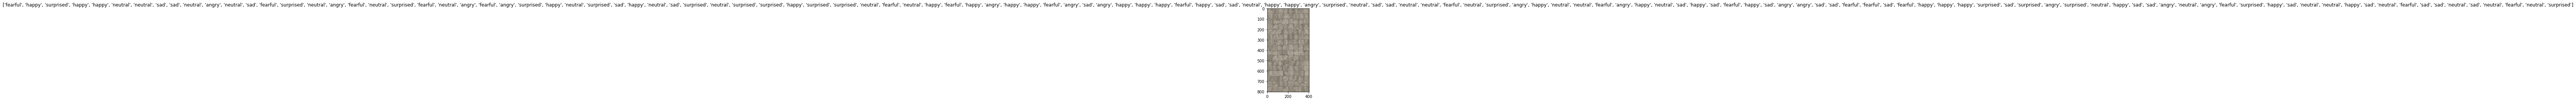

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet18(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet_adam_batch64_lr00001.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/156], Loss: 4.8448
Epoch [1/100], Step [20/156], Loss: 4.2063
Epoch [1/100], Step [40/156], Loss: 3.4655
Epoch [1/100], Step [60/156], Loss: 2.9254
Epoch [1/100], Step [80/156], Loss: 2.5027
Epoch [1/100], Step [100/156], Loss: 2.0439
Epoch [1/100], Step [120/156], Loss: 2.1320
Epoch [1/100], Step [140/156], Loss: 1.9479

train-loss: 2.7498, train-acc: 41.4178
validation loss: 1.7945, validation acc: 54.8432

Improvement-Detected, save-model
Epoch 2

Epoch [2/100], Step [0/156], Loss: 1.8517
Epoch [2/100], Step [20/156], Loss: 1.5670
Epoch [2/100], Step [40/156], Loss: 1.4368
Epoch [2/100], Step [60/156], Loss: 1.3110
Epoch [2/100], Step [80/156], Loss: 1.3289
Epoch [2/100], Step [100/156], Loss: 1.2583
Epoch [2/100], Step [120/156], Loss: 1.3304
Epoch [2/100], Step [140/156], Loss: 1.4240

train-loss: 2.0959, train-acc: 59.7896
validation loss: 1.6643, validation acc: 57.6505

Improvement-Detected, save-model
Epoch 3

Epoch [3/100], Step [0/156], Loss: 

Epoch [19/100], Step [20/156], Loss: 0.0410
Epoch [19/100], Step [40/156], Loss: 0.0065
Epoch [19/100], Step [60/156], Loss: 0.0123
Epoch [19/100], Step [80/156], Loss: 0.0039
Epoch [19/100], Step [100/156], Loss: 0.0454
Epoch [19/100], Step [120/156], Loss: 0.0066
Epoch [19/100], Step [140/156], Loss: 0.0109

train-loss: 0.3583, train-acc: 99.6743
validation loss: 2.1702, validation acc: 60.5463

Epoch 20

Epoch [20/100], Step [0/156], Loss: 0.0093
Epoch [20/100], Step [20/156], Loss: 0.0035
Epoch [20/100], Step [40/156], Loss: 0.0039
Epoch [20/100], Step [60/156], Loss: 0.0096
Epoch [20/100], Step [80/156], Loss: 0.0074
Epoch [20/100], Step [100/156], Loss: 0.0068
Epoch [20/100], Step [120/156], Loss: 0.0841
Epoch [20/100], Step [140/156], Loss: 0.0030

train-loss: 0.3409, train-acc: 99.7295
validation loss: 2.1853, validation acc: 60.3945

Epoch 21

Epoch [21/100], Step [0/156], Loss: 0.0019
Epoch [21/100], Step [20/156], Loss: 0.0022
Epoch [21/100], Step [40/156], Loss: 0.0056
Epoc

Epoch [37/100], Step [40/156], Loss: 0.0339
Epoch [37/100], Step [60/156], Loss: 0.0145
Epoch [37/100], Step [80/156], Loss: 0.0284
Epoch [37/100], Step [100/156], Loss: 0.0079
Epoch [37/100], Step [120/156], Loss: 0.0094
Epoch [37/100], Step [140/156], Loss: 0.0108

train-loss: 0.2055, train-acc: 99.3838
validation loss: 2.3211, validation acc: 60.2175

Epoch 38

Epoch [38/100], Step [0/156], Loss: 0.0090
Epoch [38/100], Step [20/156], Loss: 0.0234
Epoch [38/100], Step [40/156], Loss: 0.0072
Epoch [38/100], Step [60/156], Loss: 0.0069
Epoch [38/100], Step [80/156], Loss: 0.0034
Epoch [38/100], Step [100/156], Loss: 0.0175
Epoch [38/100], Step [120/156], Loss: 0.0274
Epoch [38/100], Step [140/156], Loss: 0.0116

train-loss: 0.2005, train-acc: 99.5741
validation loss: 2.3247, validation acc: 61.1406

Epoch 39

Epoch [39/100], Step [0/156], Loss: 0.0029
Epoch [39/100], Step [20/156], Loss: 0.0047
Epoch [39/100], Step [40/156], Loss: 0.0055
Epoch [39/100], Step [60/156], Loss: 0.0082
Epoc

Epoch [55/100], Step [60/156], Loss: 0.0074
Epoch [55/100], Step [80/156], Loss: 0.0030
Epoch [55/100], Step [100/156], Loss: 0.0145
Epoch [55/100], Step [120/156], Loss: 0.0068
Epoch [55/100], Step [140/156], Loss: 0.0128

train-loss: 0.1457, train-acc: 99.5992
validation loss: 2.3938, validation acc: 61.1153

Epoch 56

Epoch [56/100], Step [0/156], Loss: 0.0024
Epoch [56/100], Step [20/156], Loss: 0.0105
Epoch [56/100], Step [40/156], Loss: 0.0425
Epoch [56/100], Step [60/156], Loss: 0.1988
Epoch [56/100], Step [80/156], Loss: 0.0499
Epoch [56/100], Step [100/156], Loss: 0.1467
Epoch [56/100], Step [120/156], Loss: 0.0803
Epoch [56/100], Step [140/156], Loss: 0.1974

train-loss: 0.1443, train-acc: 97.9008
validation loss: 2.4013, validation acc: 58.9909

Epoch 57

Epoch [57/100], Step [0/156], Loss: 0.1294
Epoch [57/100], Step [20/156], Loss: 0.0304
Epoch [57/100], Step [40/156], Loss: 0.1020
Epoch [57/100], Step [60/156], Loss: 0.1440
Epoch [57/100], Step [80/156], Loss: 0.0593
Epoc

Epoch [73/100], Step [80/156], Loss: 0.0021
Epoch [73/100], Step [100/156], Loss: 0.0018
Epoch [73/100], Step [120/156], Loss: 0.0025
Epoch [73/100], Step [140/156], Loss: 0.1421

train-loss: 0.1169, train-acc: 99.7545
validation loss: 2.4453, validation acc: 62.1902

Epoch 74

Epoch [74/100], Step [0/156], Loss: 0.0010
Epoch [74/100], Step [20/156], Loss: 0.0102
Epoch [74/100], Step [40/156], Loss: 0.0038
Epoch [74/100], Step [60/156], Loss: 0.0076
Epoch [74/100], Step [80/156], Loss: 0.0011
Epoch [74/100], Step [100/156], Loss: 0.0025
Epoch [74/100], Step [120/156], Loss: 0.0047
Epoch [74/100], Step [140/156], Loss: 0.0115

train-loss: 0.1154, train-acc: 99.7645
validation loss: 2.4477, validation acc: 62.0132

Epoch 75

Epoch [75/100], Step [0/156], Loss: 0.0020
Epoch [75/100], Step [20/156], Loss: 0.0084
Epoch [75/100], Step [40/156], Loss: 0.0007
Epoch [75/100], Step [60/156], Loss: 0.0030
Epoch [75/100], Step [80/156], Loss: 0.0008
Epoch [75/100], Step [100/156], Loss: 0.0458
Epo

Epoch [91/100], Step [100/156], Loss: 0.0006
Epoch [91/100], Step [120/156], Loss: 0.0110
Epoch [91/100], Step [140/156], Loss: 0.0005

train-loss: 0.0971, train-acc: 99.8096
validation loss: 2.4699, validation acc: 62.5063

Epoch 92

Epoch [92/100], Step [0/156], Loss: 0.0010
Epoch [92/100], Step [20/156], Loss: 0.0007
Epoch [92/100], Step [40/156], Loss: 0.0007
Epoch [92/100], Step [60/156], Loss: 0.0004
Epoch [92/100], Step [80/156], Loss: 0.0009
Epoch [92/100], Step [100/156], Loss: 0.0005
Epoch [92/100], Step [120/156], Loss: 0.0005
Epoch [92/100], Step [140/156], Loss: 0.0009

train-loss: 0.0961, train-acc: 99.8347
validation loss: 2.4715, validation acc: 62.7972

Epoch 93

Epoch [93/100], Step [0/156], Loss: 0.0065
Epoch [93/100], Step [20/156], Loss: 0.0049
Epoch [93/100], Step [40/156], Loss: 0.0004
Epoch [93/100], Step [60/156], Loss: 0.0066
Epoch [93/100], Step [80/156], Loss: 0.0094
Epoch [93/100], Step [100/156], Loss: 0.0010
Epoch [93/100], Step [120/156], Loss: 0.0006
Ep

In [8]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i] / 100
for i in range(len(val_acc)):
    val_acc[i] = val_acc[i] / 100


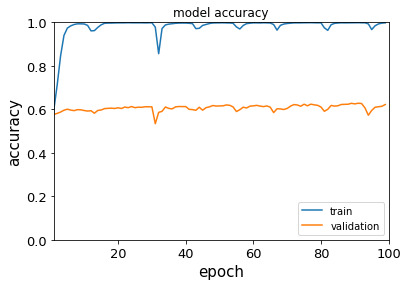

In [9]:
fig = plt.title("model accuracy")
plt.plot(train_acc)
plt.plot(val_acc)
plt.axis([1, 100, 0, 1])
plt.ylabel("accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("epoch", fontsize=15)
plt.legend(["train", "validation"], loc="lower right")
plt.show()